### Import dataset

In [249]:
# import dataset with real data
import pandas as pd
import csv

df = pd.read_csv("pfaf_plants_merged.csv")

### Clean dataset

In [250]:
# delete numerical columns (except USDA hardiness), binary columns, and URLs
df = df.drop(columns=["edibility_rating_search", "medicinal_rating_search", "plant_url", "Edibility Rating", "Image URLs", "Medicinal Rating", "Other Uses Rating", "Weed Potential"])

# delete columns with redundant information
df = df.drop(columns=["Common Name", "Common Names", "Scientific Name", "Summary"])

### Assign to the USDA hardiness numerical zones, the text description

In [251]:
# create a mapping for USDA hardiness zones
climate_zone = {
    "1": "arctic/alpine",
    "2": "arctic/alpine",
    "3": "boreal",
    "4": "boreal",
    "5": "cool temperate",
    "6": "cool temperate",
    "7": "temperate",
    "8": "temperate",
    "9": "subtropical",
    "10": "subtropical",
    "11": "tropical",
    "12": "tropical",
    "13": "tropical"
}

# define a function to map USDA hardiness zones to descriptions
import numpy as np

def parse_usda_range(zone_str):
    if not isinstance(zone_str, str):
        return set()  # or return None
    zone_str = zone_str.replace(" ", "")
    zones = set()
    parts = zone_str.split(",")
    
    for part in parts:
        if "-" in part:
            try:
                start, end = part.split("-")
                zones.update(str(i) for i in range(int(start), int(end) + 1))
            except ValueError:
                continue  # skip malformed ranges
        else:
            zones.add(part)
    
    return zones

# map the USDA hardiness zones to their descriptions
def get_zone_description(zone_str):
    zones = parse_usda_range(zone_str)
    if not zones:
        return np.nan
    descriptions = set()
    for zone in zones:
        if zone in climate_zone:
            descriptions.add(climate_zone[zone])
    return ", ".join(sorted(descriptions)) if descriptions else np.nan

# apply to the dataframe and create a new column with the descriptions
df["climate_zone"] = df["USDA hardiness"].apply(get_zone_description)

# then drop the USDA hardiness column
df = df.drop(columns=["USDA hardiness"])

### Clean the rich-text columns (delete extra spaces and convert to lowercase, except for the geographical information)

In [252]:
import re
import spacy

# load a small English model 
nlp = spacy.load("en_core_web_sm")

def clean_text_space_lowercase(text, to_lower=True):
    if pd.isna(text):
        return ""
    text = re.sub(r"\s+", " ", text.strip())  # remove extra spaces
    if to_lower:
        text = text.lower() # convert to lowercase
    return text

df["Common names"] = df["common_name_search"].apply(clean_text_space_lowercase)
df["Care requirements"] = df["Care Requirements"].apply(clean_text_space_lowercase)
df["Cultivation details"] = df["Cultivation Details"].apply(clean_text_space_lowercase)
df["Edible uses"] = df["Edible Uses"].apply(clean_text_space_lowercase)
df["Known hazards"] = df["Known Hazards"].apply(clean_text_space_lowercase)
df["Medicinal properties"] = df["Medicinal Properties"].apply(clean_text_space_lowercase)
df["Other uses"] = df["Other Uses"].apply(clean_text_space_lowercase)
df["Propagation"] = df["Propagation"].apply(clean_text_space_lowercase)
df["Special uses"] = df["Special Uses"].apply(clean_text_space_lowercase)
df["Climatic zone"] = df["climate_zone"].apply(clean_text_space_lowercase)

def clean_text_space(text):
    if pd.isna(text):
        return ""
    text = re.sub(r"\s+", " ", text.strip())  # remove extra spaces
    return text

df["Native area"] = df["Native Range"].apply(clean_text_space)
df["Diffusion area"] = df["Range"].apply(clean_text_space)

In [253]:
# delete the columns that are not needed anymore
df = df.drop(columns=["common_name_search", "Care Requirements", "Cultivation Details", "Edible Uses", "Known Hazards", "Medicinal Properties", "Other Uses", "Special Uses", "climate_zone", "Native Range", "Range"])

In [254]:
# modify name of some columns
df = df.rename(columns={
    "use_keyword" : "General use",
    "latin_name_search" : "Scientific name"
})

### Chunking the columns with a more structured text

In [255]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Now when you print or display a DataFrame, it shows everything
df.head()

,General use,Scientific name,Family,Propagation,Common names,Care requirements,Cultivation details,Edible uses,Known hazards,Medicinal properties,Other uses,Special uses,Climatic zone,Native area,Diffusion area
0,Stomachic,Abelmoschus moschatus,Malvaceae,seed - sow april in a greenhouse. the seed ger...,"musk mallow,musk okra",moist soil; half hardy; full sun,easily grown in a rich well-drained soil in a ...,edible parts: leaves oil root seed seedpod sho...,none known,antihalitosis; antispasmodic; aphrodisiac; app...,essential fibre insecticide oil size an essent...,scented plants,"subtropical, temperate, tropical","TEMPERATE ASIA: China (Hunan Sheng, Jiangxi Sh...",S.E. Asia - Himalayas to China and Vietnam.
1,Stomachic,Abies grandis,Pinaceae,seed - sow early february in a greenhouse or o...,"grand fir, giant fir, lowland white fir",semi-shade; fully hardy; moist soil; full shad...,"landscape uses:screen, specimen. prefers a goo...",edible parts: inner bark shoots edible uses: d...,none known,antirheumatic; laxative; ophthalmic; skin; sto...,baby care dye gum incense repellent roofing wo...,food forest scented plants,cool temperate,"NORTHERN AMERICA: Canada (British Columbia), U...",Western N. America - British Columbia to Calif...
2,Stomachic,Abies spectabilis,Pinaceae,seed - sow early february in a greenhouse or o...,himalayan fir,semi-shade; fully hardy; moist soil; full shad...,prefers a good moist but not water-logged soil...,none known,none known,antiperiodic; astringent; carminative; expecto...,essential fuel incense wood an essential oil i...,scented plants,"cool temperate, subtropical, temperate","TEMPERATE ASIA: Afghanistan, China (Xizang Ziz...",E. Asia - Himalayas from Afghanistan to Nepal.
3,Stomachic,Abutilon theophrasti,Malvaceae,seed - sow early april in a greenhouse. germin...,"china jute, velvetleaf, butterprint buttonweed...",semi-shade; fully hardy; well drained soil; mo...,requires full sun or part day shade and a fert...,edible parts: fruit oil seed edible uses: oil ...,none known,astringent; demulcent; diuretic; dysentery; em...,fibre oil paper a fibre obtained from the stem...,,,"TEMPERATE ASIA: Afghanistan, Egypt (Sinai), Ir...",Asia - tropical. Naturalised in S.E. Europe an...
4,Stomachic,Acacia farnesiana,Fabaceae or Leguminosae,seed - best sown as soon as it is ripe in a su...,"sweet acacia, perfume acacia, huisache",moist soil; frost hardy; full sun; well draine...,landscape uses: pest tolerant. originally trop...,edible parts: edible uses: gum gum a low-quali...,"the seeds, containing an unnamed alkaloid, are...",astringent; demulcent; dysentery; poultice; st...,adhesive dye essential gum gum ink tannin teet...,nitrogen fixer scented plants,"subtropical, tropical",NORTHERN AMERICA: United States (Florida (nort...,"The original range is uncertain, but is probab..."


In [256]:
def extract_phrases(text):
    if pd.isna(text):
        return []
    phrases = re.split(r"[;,:.]", text)
    return [phrase.strip().lower() for phrase in phrases if phrase.strip()]

df["Common names_phrases"] = df["Common names"].apply(extract_phrases)
df["Care requirements_phrases"] = df["Care requirements"].apply(extract_phrases)
df["Cultivation details_phrases"] = df["Cultivation details"].apply(extract_phrases)
df["Edible uses_phrases"] = df["Edible uses"].apply(extract_phrases)
df["Known hazards_phrases"] = df["Known hazards"].apply(extract_phrases)
df["Medicinal properties_phrases"] = df["Medicinal properties"].apply(extract_phrases)
df["Climatic zone_phrases"] = df["Climatic zone"].apply(extract_phrases)

In [257]:
df.shape

(17950, 22)

### Propagation
- prepare the column for further visualization

In [258]:
# split the text into phrases based on periods followed by space or end of line
def split_phrases(text):
    if pd.isna(text):
        return []
    return [phrase.strip().lower() for phrase in re.split(r"[.]\s*", text) if phrase.strip()]

# define keyword-based categorization
def categorize_phrase(phrase):
    if not isinstance(phrase, str):
        return "unknown"
    
    phrase = phrase.lower()
    if any(kw in phrase for kw in ["sow", "sown", "sowing"]):
        return "sowing"
    elif any(kw in phrase for kw in ["stratification", "scarify", "pre-soak"]):
        return "seed preparation"
    elif any(kw in phrase for kw in ["germinate", "germination"]):
        return "germination"
    elif any(kw in phrase for kw in ["prick", "pots", "seedlings"]):
        return "first potting"
    elif "division" in phrase:
        return "division"
    elif any(kw in phrase for kw in ["plant out", "permanent position", "planted"]):
        return "first planting"
    elif any(kw in phrase for kw in ["cutting", "basal", "half-ripe"]):
        return "cutting"
    elif any(kw in phrase for kw in ["collect", "pot", "shoots"]):
        return "second potting"        
    elif any(kw in phrase for kw in ["root", "ready", "plant"]):
        return "second planting"
    else:
        return "other"

# apply the function to the Propagation column
# split and categorize
df["propagation_steps"] = df["Propagation"].apply(split_phrases)

# expand and categorize
df_exploded = df.explode("propagation_steps").copy()
df_exploded["propagation_phase"] = df_exploded["propagation_steps"].apply(categorize_phrase)

# group by family and propagation phase
df_family = (df_exploded.groupby(["Family", "propagation_phase", "propagation_steps"]).size().reset_index(name="count"))

The df_exploded with the code above and the division of df["Propagation"] into df["propagation_steps"] and df["propagation_phase"] could be used into a model.

In [259]:
# extract the number of weeks/months from the propagation phase sowing
import re
import numpy as np

def extract_germination_time(text):
    if pd.isna(text):
        return np.nan

    # Normalize text
    text = text.lower()

    # Match expressions like "germinate... X weeks" or "germination... X - Y weeks"
    pattern = r"(?:germinates|germination(?: takes| is)?)(?:.*?)(\d+)(?:\s*[-to]{1,3}\s*(\d+))?\s*(weeks?|months?)"

    match = re.search(pattern, text)
    if match:
        start = int(match.group(1))
        end = match.group(2)
        unit = match.group(3)

        if end:
            end = int(end)
            avg = (start + end) / 2
        else:
            avg = start

        if "month" in unit:
            avg *= 4  # convert months to weeks

        return avg  # return average germination time in weeks

    return np.nan

# apply the function to the Propagation column
df["germination_weeks"] = df["Propagation"].apply(extract_germination_time)

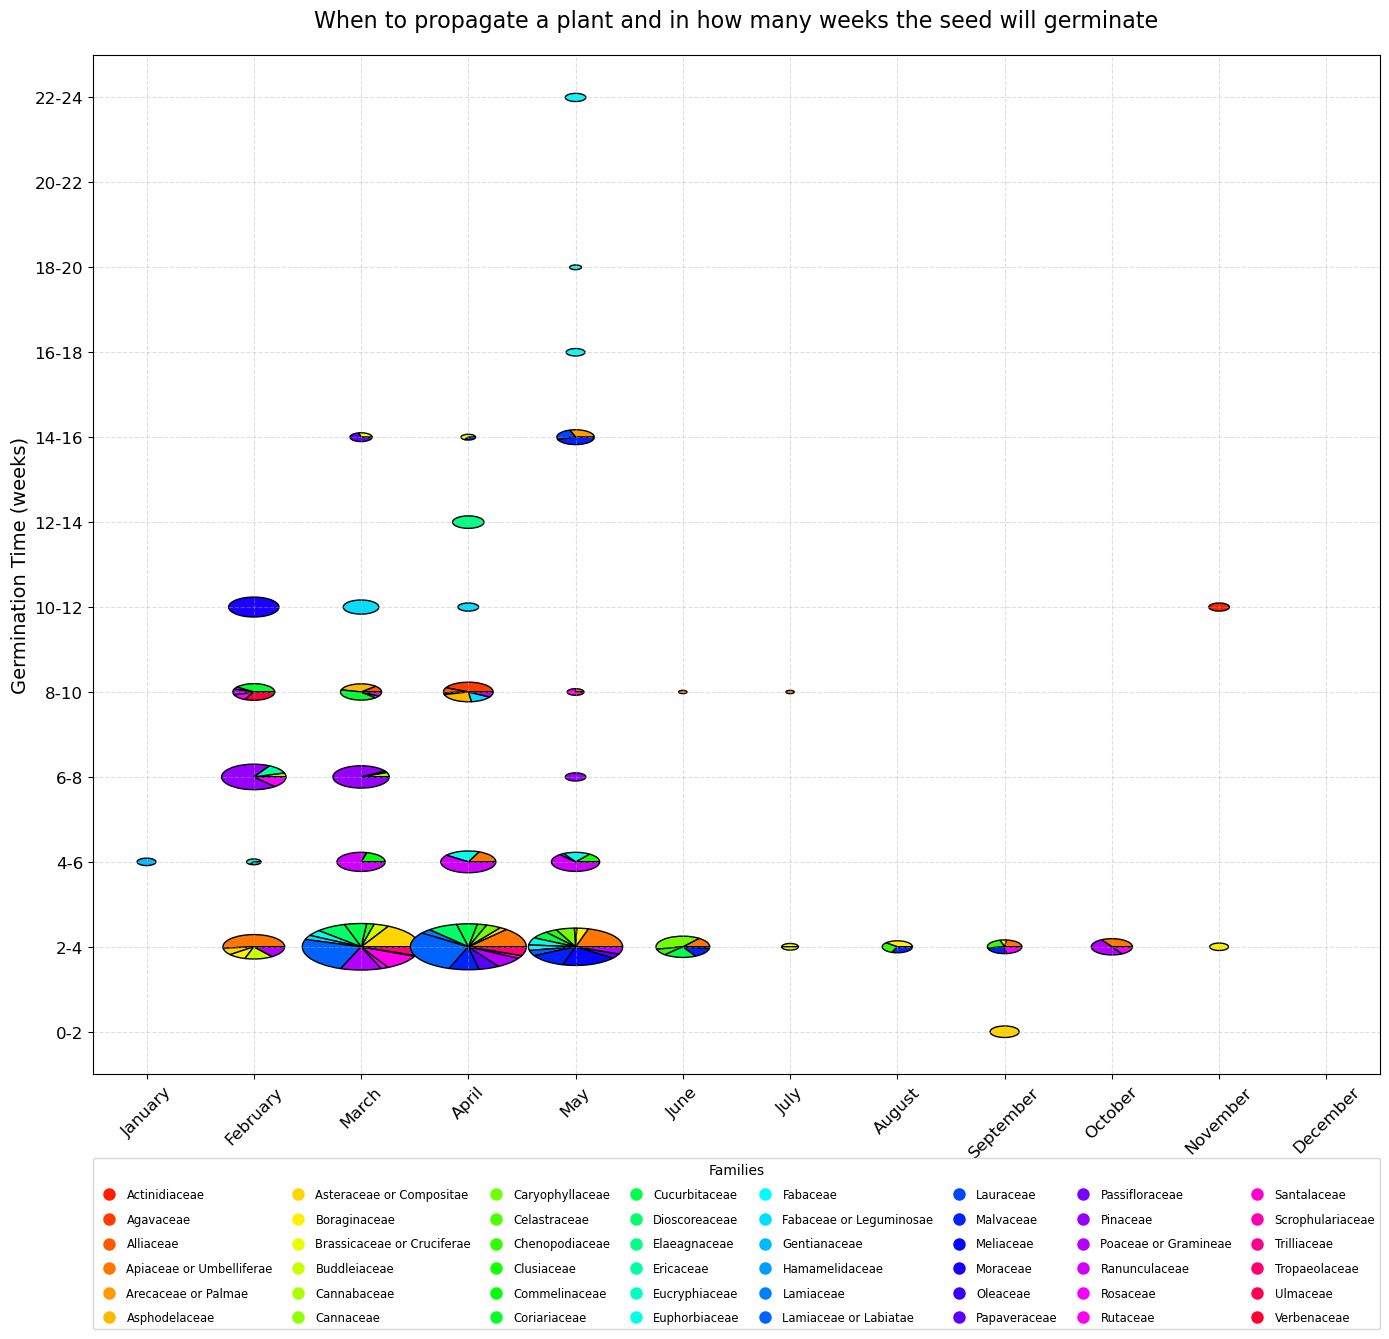

In [260]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import seaborn as sns  # import seaborn for palette

# --- Function to extract months from a text ---
def extract_months(text):
    if pd.isna(text):
        return []
    months = [
        "january", "february", "march", "april", "may", "june",
        "july", "august", "september", "october", "november", "december"
    ]
    found = []
    for m in months:
        if re.search(rf"\b{m}\b", str(text).lower()):
            found.append(m.capitalize())
    return found

# --- Function to detect sowing-related propagation steps ---
def is_sowing_step(text):
    if pd.isna(text):
        return False
    return bool(re.search(r"\bsow|seeding|plant\b", text.lower()))

# Split propagation column into steps (lowercase and stripped)
df["propagation_steps"] = df["Propagation"].apply(
    lambda text: [] if pd.isna(text) else [p.strip().lower() for p in re.split(r"[.]\s*", text) if p.strip()]
)

# Keep only sowing-related steps
df["sowing_steps"] = df["propagation_steps"].apply(
    lambda steps: [s for s in steps if is_sowing_step(s)]
)

# Explode sowing steps for month extraction
df_exploded = df.explode("sowing_steps").copy()

# Extract months only from sowing steps
df_exploded["sowing_months"] = df_exploded["sowing_steps"].apply(extract_months)

# Explode months and drop missing months or germination weeks
df_months = df_exploded.explode("sowing_months").dropna(subset=["sowing_months"])
df_months = df_months.dropna(subset=["germination_weeks"])
df_months_filtered = df_months.copy()

# Map month names to numeric x values
month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]
month_to_num = {m: i for i, m in enumerate(month_order)}

df_months_filtered.loc[:, "month_num"] = df_months_filtered["sowing_months"].map(month_to_num)

# Define germination time bins (y-axis)
bins = list(range(0, 26, 2))  # [0, 2, 4, ..., 24]
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]
df_months_filtered.loc[:, "germ_bin"] = pd.cut(df_months_filtered["germination_weeks"], bins=bins, labels=labels, right=False)

# Group by month_num, germ_bin, Family to get counts
grouped = df_months_filtered.groupby(["month_num", "germ_bin", "Family"], observed=True).size().reset_index(name='count')

# Pivot to get families as columns
pivot = grouped.pivot_table(index=["month_num", "germ_bin"], columns="Family", values="count", fill_value=0, observed=True)

# Calculate total count per bin for circle size
pivot["total"] = pivot.sum(axis=1)

# Remove zero totals
pivot = pivot[pivot["total"] > 0]

# Prepare plot
fig, ax = plt.subplots(figsize=(14, 15))

# Normalize circle sizes
max_size = 3000  # max circle area
pivot["size"] = (pivot["total"] / pivot["total"].max()) * max_size

# Calculate germination bin centers for y-axis
germ_bin_centers = {label: (bins[i] + bins[i+1]) / 2 for i, label in enumerate(labels)}

# Colors for families
unique_families = sorted(df_months_filtered["Family"].unique())
palette = sns.color_palette("hsv", len(unique_families))
family_colors = {fam: palette[i] for i, fam in enumerate(unique_families)}

# Function to draw pie charts at given positions
def draw_pie(ax, xpos, ypos, sizes, colors, size):
    start = 0
    for frac, color in zip(sizes, colors):
        if frac == 0:
            continue
        theta1 = start * 360
        theta2 = (start + frac) * 360
        wedge = plt.matplotlib.patches.Wedge(center=(xpos, ypos), r=size,
                                            theta1=theta1, theta2=theta2,
                                            facecolor=color, edgecolor='k')
        ax.add_patch(wedge)
        start += frac

# Plot pie charts for each month_num and germ_bin
for (month_num, germ_bin), row in pivot.iterrows():
    ypos = germ_bin_centers[germ_bin]
    xpos = month_num
    size = np.sqrt(row["size"]) / 100  # adjust scale as needed

    family_counts = row.drop(["total", "size"])
    total = family_counts.sum()
    fracs = family_counts / total if total > 0 else family_counts

    draw_pie(ax, xpos, ypos, fracs, [family_colors[fam] for fam in family_counts.index], size)

# Format axes and labels
ax.set_xticks(range(len(month_order)))
ax.set_xticklabels(month_order, rotation=45, fontsize=12)
ax.set_ylabel("Germination Time (weeks)", fontsize=14)
ax.set_yticks(list(germ_bin_centers.values()))
ax.set_yticklabels(labels, fontsize=12)
ax.set_xlim(-0.5, 11.5)
ax.set_ylim(min(bins), max(bins))
ax.grid(True, linestyle='--', alpha=0.4)

# Legend for families below plot
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=fam,
               markerfacecolor=family_colors[fam], markersize=10)
    for fam in unique_families
]

ax.legend(handles=handles, title="Families",
          loc='lower center',
          bbox_to_anchor=(0, -0.25, 1, 0.3),
          mode='expand', borderaxespad=0,
          ncol=8,
          fontsize='small',
          handletextpad=0.5,
          labelspacing=1.0)

plt.subplots_adjust(bottom=0.4)  # bottom margin for legend
plt.title("When to propagate a plant and in how many weeks the seed will germinate", fontsize=16, pad=20)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

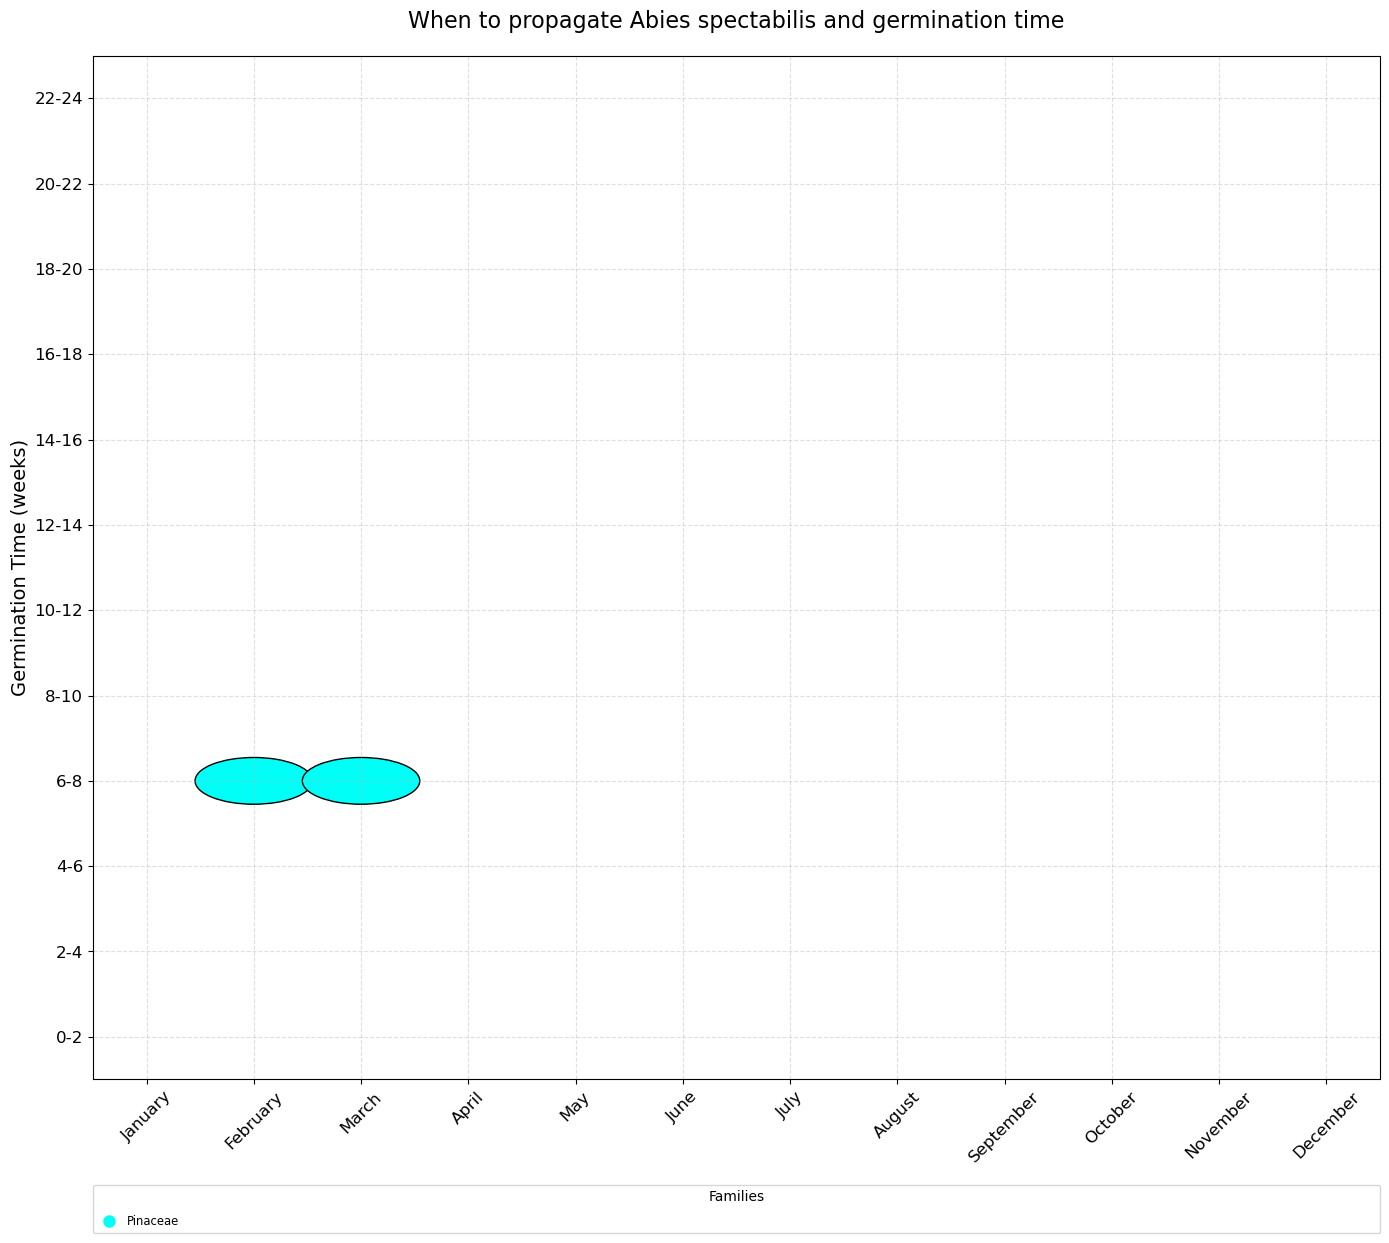

In [261]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import seaborn as sns  # import seaborn for palette

# --- Function to extract months from a text ---
def extract_months(text):
    if pd.isna(text):
        return []
    months = [
        "january", "february", "march", "april", "may", "june",
        "july", "august", "september", "october", "november", "december"
    ]
    found = []
    for m in months:
        if re.search(rf"\b{m}\b", str(text).lower()):
            found.append(m.capitalize())
    return found

# --- Function to detect sowing-related propagation steps ---
def is_sowing_step(text):
    if pd.isna(text):
        return False
    return bool(re.search(r"\bsow|seeding|plant\b", text.lower()))

def plot_plant_germination(df, plant_name):
    # Filter for the plant
    df_plant = df[df["Scientific name"].str.lower() == plant_name.lower()].copy()
    
    if df_plant.empty:
        print(f"No data found for plant: {plant_name}")
        return
    
    # Split propagation column into steps (lowercase and stripped)
    df_plant["propagation_steps"] = df_plant["Propagation"].apply(
        lambda text: [] if pd.isna(text) else [p.strip().lower() for p in re.split(r"[.]\s*", text) if p.strip()]
    )
    
    # Keep only sowing-related steps
    df_plant["sowing_steps"] = df_plant["propagation_steps"].apply(
        lambda steps: [s for s in steps if is_sowing_step(s)]
    )
    
    # Explode sowing steps for month extraction
    df_exploded = df_plant.explode("sowing_steps").copy()
    
    # Extract months only from sowing steps
    df_exploded["sowing_months"] = df_exploded["sowing_steps"].apply(extract_months)
    
    # Explode months and drop missing months or germination weeks
    df_months = df_exploded.explode("sowing_months").dropna(subset=["sowing_months"])
    df_months = df_months.dropna(subset=["germination_weeks"])
    df_months_filtered = df_months.copy()
    
    # Map month names to numeric x values
    month_order = [
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]
    month_to_num = {m: i for i, m in enumerate(month_order)}
    
    df_months_filtered.loc[:, "month_num"] = df_months_filtered["sowing_months"].map(month_to_num)
    
    # Define germination time bins (y-axis)
    bins = list(range(0, 26, 2))  # [0, 2, 4, ..., 24]
    labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]
    df_months_filtered.loc[:, "germ_bin"] = pd.cut(df_months_filtered["germination_weeks"], bins=bins, labels=labels, right=False)
    
    # Group by month_num, germ_bin, Family to get counts
    grouped = df_months_filtered.groupby(["month_num", "germ_bin", "Family"], observed=True).size().reset_index(name='count')
    
    # Pivot to get families as columns
    pivot = grouped.pivot_table(index=["month_num", "germ_bin"], columns="Family", values="count", fill_value=0, observed=True)
    
    # Calculate total count per bin for circle size
    pivot["total"] = pivot.sum(axis=1)
    
    # Remove zero totals
    pivot = pivot[pivot["total"] > 0]
    
    if pivot.empty:
        print(f"No sowing and germination data available to plot for {plant_name}.")
        return
    
    # Prepare plot
    fig, ax = plt.subplots(figsize=(14, 15))
    
    # Normalize circle sizes
    max_size = 3000  # max circle area
    pivot["size"] = (pivot["total"] / pivot["total"].max()) * max_size
    
    # Calculate germination bin centers for y-axis
    germ_bin_centers = {label: (bins[i] + bins[i+1]) / 2 for i, label in enumerate(labels)}
    
    # Colors for families
    unique_families = sorted(df_months_filtered["Family"].unique())
    palette = sns.color_palette("hsv", len(unique_families))
    family_colors = {fam: palette[i] for i, fam in enumerate(unique_families)}
    
    # Function to draw pie charts at given positions
    def draw_pie(ax, xpos, ypos, sizes, colors, size):
        start = 0
        for frac, color in zip(sizes, colors):
            if frac == 0:
                continue
            theta1 = start * 360
            theta2 = (start + frac) * 360
            wedge = plt.matplotlib.patches.Wedge(center=(xpos, ypos), r=size,
                                                theta1=theta1, theta2=theta2,
                                                facecolor=color, edgecolor='k')
            ax.add_patch(wedge)
            start += frac
    
    # Plot pie charts for each month_num and germ_bin
    for (month_num, germ_bin), row in pivot.iterrows():
        ypos = germ_bin_centers[germ_bin]
        xpos = month_num
        size = np.sqrt(row["size"]) / 100  # adjust scale as needed
    
        family_counts = row.drop(["total", "size"])
        total = family_counts.sum()
        fracs = family_counts / total if total > 0 else family_counts
    
        draw_pie(ax, xpos, ypos, fracs, [family_colors[fam] for fam in family_counts.index], size)
    
    # Format axes and labels
    ax.set_xticks(range(len(month_order)))
    ax.set_xticklabels(month_order, rotation=45, fontsize=12)
    ax.set_ylabel("Germination Time (weeks)", fontsize=14)
    ax.set_yticks(list(germ_bin_centers.values()))
    ax.set_yticklabels(labels, fontsize=12)
    ax.set_xlim(-0.5, 11.5)
    ax.set_ylim(min(bins), max(bins))
    ax.grid(True, linestyle='--', alpha=0.4)
    
    # Legend for families below plot
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label=fam,
                   markerfacecolor=family_colors[fam], markersize=10)
        for fam in unique_families
    ]
    
    ax.legend(handles=handles, title="Families",
              loc='lower center',
              bbox_to_anchor=(0, -0.15, 1, 0.3),
              mode='expand', borderaxespad=0,
              ncol=8,
              fontsize='small',
              handletextpad=0.5,
              labelspacing=1.0)
    
    plt.subplots_adjust(bottom=0.1)  # bottom margin for legend
    plt.title(f"When to propagate {plant_name} and germination time", fontsize=16, pad=20)
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.show()

# Usage example:
plot_plant_germination(df, "Abies spectabilis")

### Native area - Diffusion area

Use chunking, not just tokenization, before NER:

1. Split by commas → gives you candidate chunks
2. Strip parentheses content when needed
3. Apply NER on chunks
4. Fallback to pycountry check

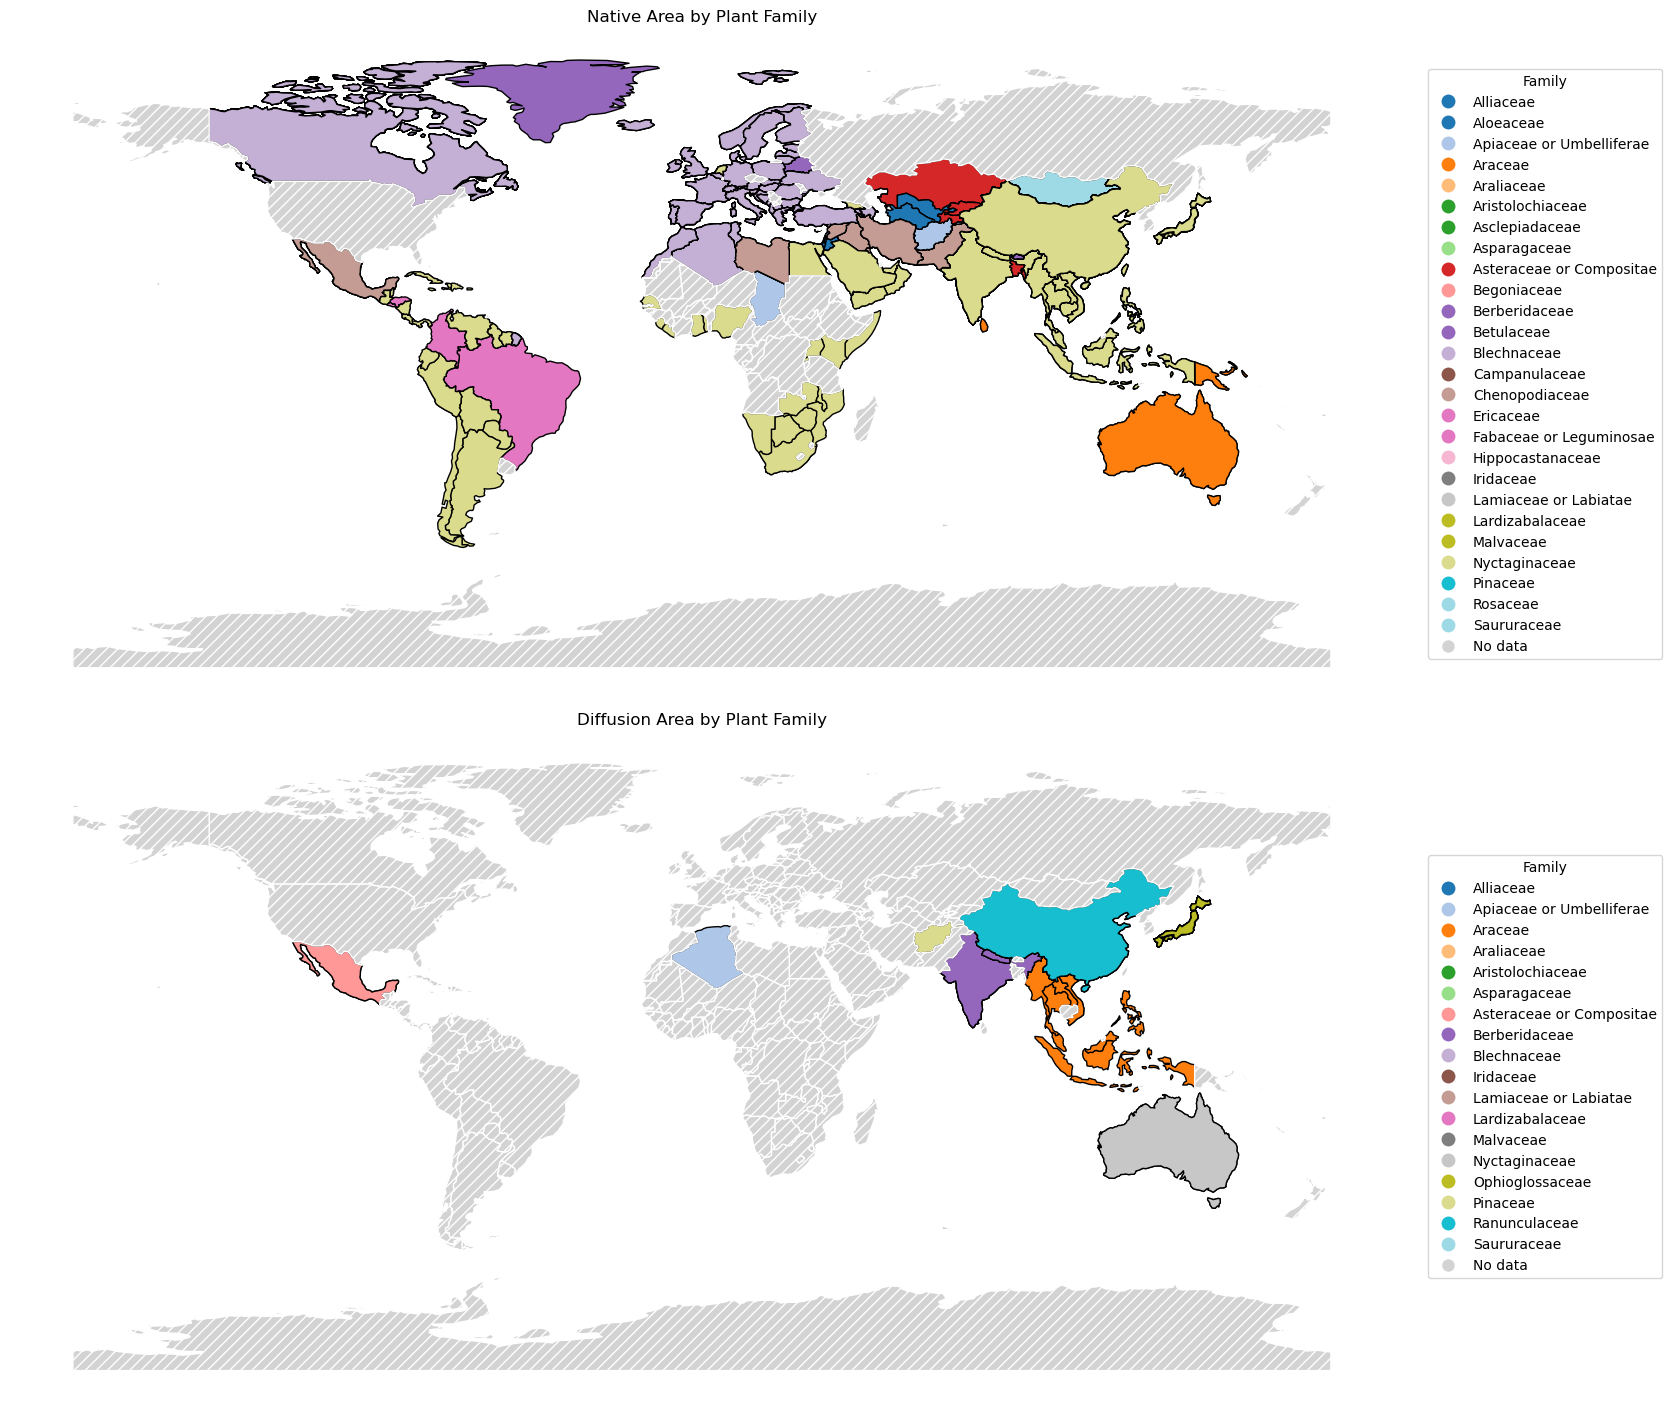

In [265]:
import spacy
import pycountry
import re
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.io.shapereader as shpreader

# --------------------
# Load NER model and known location sets
# --------------------
nlp = spacy.load("en_core_web_sm")
known_countries = {c.name for c in pycountry.countries}
known_subdivisions = {s.name for s in pycountry.subdivisions}

def extract_geographical_scope_tokenized(text):
    found = set()
    if not isinstance(text, str):
        return []
    chunks = [c.strip() for c in text.split(",")]
    for chunk in chunks:
        cleaned = re.sub(r"\(.*?\)", "", chunk).strip()
        doc = nlp(cleaned)
        for ent in doc.ents:
            if ent.label_ == "GPE":
                found.add(ent.text.strip())
        if cleaned in known_countries or cleaned in known_subdivisions:
            found.add(cleaned)
    return sorted(found)

# --------------------
# 1. Use a SUBSET of your original df
# --------------------
df_subset = df.head(100).copy()  # adjust number as needed

# --------------------
# 2. Add NER-extracted country columns (non-destructive to full df)
# --------------------
df_subset["native_countries"] = df_subset["Native area"].apply(extract_geographical_scope_tokenized)
df_subset["diffusion_countries"] = df_subset["Diffusion area"].apply(extract_geographical_scope_tokenized)

# --------------------
# 3. Explode into long format: one row per (Family, country)
# --------------------
native = df_subset[["Family", "native_countries"]].explode("native_countries").rename(columns={"native_countries": "country"})
diffusion = df_subset[["Family", "diffusion_countries"]].explode("diffusion_countries").rename(columns={"diffusion_countries": "country"})

# --------------------
# 4. Load world shapefile (Cartopy downloads once)
# --------------------
shpfilename = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
world = gpd.read_file(shpfilename)

# --------------------
# 5. Merge extracted data into a copy of the map (non-destructive to df)
# --------------------
world_native = world.copy()
world_diffusion = world.copy()

# Add empty Family column (to be filled via merge)
world_native["Family"] = np.nan
world_diffusion["Family"] = np.nan

# Merge Family info into the map
world_native = world_native.merge(native.drop_duplicates(subset=["Family", "country"]),
                                  left_on="ADMIN", right_on="country", how="left")
world_native["Family"] = world_native["Family_y"]
world_native.drop(columns=["country", "Family_x", "Family_y"], inplace=True)

world_diffusion = world_diffusion.merge(diffusion.drop_duplicates(subset=["Family", "country"]),
                                        left_on="ADMIN", right_on="country", how="left")
world_diffusion["Family"] = world_diffusion["Family_y"]
world_diffusion.drop(columns=["country", "Family_x", "Family_y"], inplace=True)

# --------------------
# 6. Plot Native & Diffusion area maps
# --------------------
fig, axes = plt.subplots(2, 1, figsize=(18, 14), constrained_layout=True)

# Plot Native Area
world_native.plot(column="Family",
                  ax=axes[0],
                  cmap="tab20",
                  legend=True,
                  edgecolor="black",
                  legend_kwds={
                      "loc": "center left",
                      "bbox_to_anchor": (1.02, 0.5),
                      "title": "Family"
                  },
                  missing_kwds={
                      "color": "lightgray",
                      "edgecolor": "white",
                      "hatch": "///",
                      "label": "No data",
                  })
axes[0].set_title("Native Area by Plant Family")
axes[0].axis("off")

# Plot Diffusion Area
world_diffusion.plot(column="Family",
                     ax=axes[1],
                     cmap="tab20",
                     legend=True,
                     edgecolor="black",
                     legend_kwds={
                         "loc": "center left",
                         "bbox_to_anchor": (1.02, 0.5),
                         "title": "Family"
                     },
                     missing_kwds={
                         "color": "lightgray",
                         "edgecolor": "white",
                         "hatch": "///",
                         "label": "No data",
                     })
axes[1].set_title("Diffusion Area by Plant Family")
axes[1].axis("off")

plt.show()

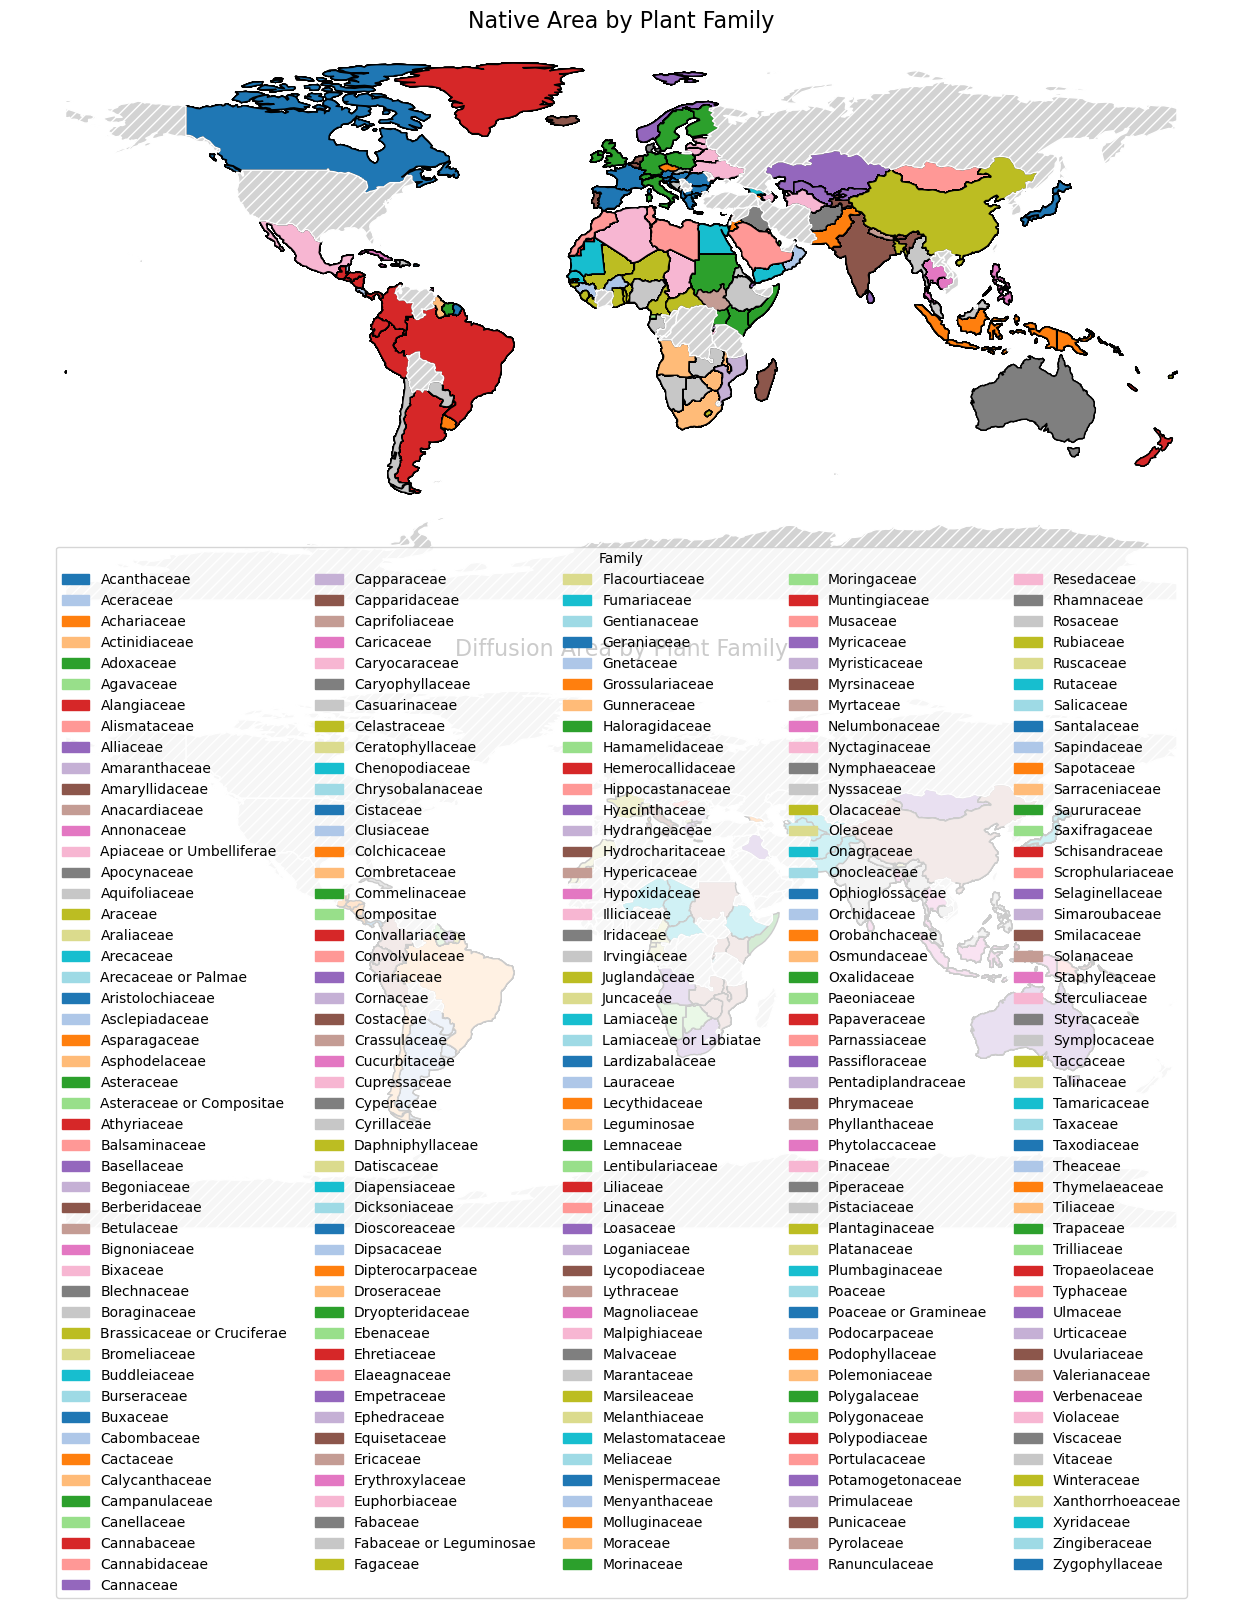

In [274]:
import pycountry
import re
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.io.shapereader as shpreader

# Load known countries and subdivisions
known_countries = {c.name for c in pycountry.countries}
known_subdivisions = {s.name for s in pycountry.subdivisions}

# ----------- FAST GEOGRAPHICAL EXTRACTION (no spaCy) ----------- #
def extract_geographical_scope_fast(text):
    if not isinstance(text, str):
        return []

    found = set()
    chunks = [re.sub(r"\(.*?\)", "", c).strip() for c in text.split(",")]

    for chunk in chunks:
        if chunk in known_countries or chunk in known_subdivisions:
            found.add(chunk)
        else:
            # Try loose match
            for country in known_countries:
                if chunk.lower() in country.lower():
                    found.add(country)
                    break

    return sorted(found)

# ----------- YOUR FULL DF IS ALREADY LOADED BEFORE THIS POINT ----------- #
# We only add new columns; df is not overwritten

# Extract countries
df["native_countries"] = df["Native area"].apply(extract_geographical_scope_fast)
df["diffusion_countries"] = df["Diffusion area"].apply(extract_geographical_scope_fast)

# Explode to long format
native = df[["Family", "native_countries"]].explode("native_countries").rename(columns={"native_countries": "country"})
diffusion = df[["Family", "diffusion_countries"]].explode("diffusion_countries").rename(columns={"diffusion_countries": "country"})

# Load Natural Earth countries
shpfilename = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
world = gpd.read_file(shpfilename)

# Prepare for native and diffusion overlays
world_native = world.copy()
world_diffusion = world.copy()
world_native["Family"] = np.nan
world_diffusion["Family"] = np.nan

# Merge family info for native area
world_native = world_native.merge(native.drop_duplicates(subset=["Family", "country"]),
                                  left_on="ADMIN", right_on="country", how="left")
world_native["Family"] = world_native["Family_y"]
world_native.drop(columns=["country", "Family_x", "Family_y"], inplace=True)

# Merge family info for diffusion area
world_diffusion = world_diffusion.merge(diffusion.drop_duplicates(subset=["Family", "country"]),
                                        left_on="ADMIN", right_on="country", how="left")
world_diffusion["Family"] = world_diffusion["Family_y"]
world_diffusion.drop(columns=["country", "Family_x", "Family_y"], inplace=True)

# ----------- PLOTTING ----------- #
import matplotlib.patches as mpatches

fig, axes = plt.subplots(2, 1, figsize=(18, 14))

# Use a consistent colormap across both plots
cmap = plt.get_cmap("tab20")

# Get all unique families from both maps
all_families = pd.concat([world_native["Family"].dropna(),
                          world_diffusion["Family"].dropna()]).unique()
all_families = sorted(all_families)

# Create a mapping: Family → Color
color_mapping = {fam: cmap(i % 20) for i, fam in enumerate(all_families)}

# Plot Native
world_native.plot(column="Family",
                  ax=axes[0],
                  cmap=cmap,
                  legend=False,
                  edgecolor="black",
                  missing_kwds={
                      "color": "lightgray",
                      "edgecolor": "white",
                      "hatch": "///",
                      "label": "No data"
                  })
axes[0].set_title("Native Area by Plant Family", fontsize=16)
axes[0].axis("off")

# Plot Diffusion
world_diffusion.plot(column="Family",
                     ax=axes[1],
                     cmap=cmap,
                     legend=False,
                     edgecolor="black",
                     missing_kwds={
                         "color": "lightgray",
                         "edgecolor": "white",
                         "hatch": "///",
                         "label": "No data"
                     })
axes[1].set_title("Diffusion Area by Plant Family", fontsize=16)
axes[1].axis("off")

# Custom legend below
patches = [mpatches.Patch(color=color_mapping[fam], label=fam) for fam in all_families]

# Add legend below the plots
fig.legend(handles=patches,
           loc="lower center",
           bbox_to_anchor=(0.5, -0.15),
           ncol=5,  # Adjust based on how many families
           fontsize=10,
           title="Family")

plt.tight_layout()
plt.subplots_adjust(bottom=0.10)  # Make room for the legend
plt.show()

### General use - cultivation details (plant characteristics) - native area - edible uses

In [128]:
df["General use"].head()

1    Stomachic
2    Stomachic
3    Stomachic
4    Stomachic
5    Stomachic
Name: General use, dtype: object

In [129]:
df["Edible uses_phrases"].head()

1    [edible parts, inner bark shoots edible uses, ...
2                                         [none known]
3    [edible parts, fruit oil seed edible uses, oil...
4    [edible parts, edible uses, gum gum a low-qual...
5                                         [none known]
Name: Edible uses_phrases, dtype: object

In [130]:
df["Native area"].head()

1    NORTHERN AMERICA: Canada (British Columbia), U...
2    TEMPERATE ASIA: Afghanistan, China (Xizang Ziz...
3    TEMPERATE ASIA: Afghanistan, Egypt (Sinai), Ir...
4    NORTHERN AMERICA: United States (Florida (nort...
5                                          Coming Soon
Name: Native area, dtype: object

In [131]:
df["Cultivation details_phrases"].head()

1    [landscape uses, screen, specimen, prefers a g...
2    [prefers a good moist but not water-logged soi...
3    [requires full sun or part day shade and a fer...
4    [landscape uses, pest tolerant, originally tro...
5    [succeeds in most soils but prefers a well-dra...
Name: Cultivation details_phrases, dtype: object

In [133]:
df["Diffusion area"].head()

1    Western N. America - British Columbia to Calif...
2       E. Asia - Himalayas from Afghanistan to Nepal.
3    Asia - tropical. Naturalised in S.E. Europe an...
4    The original range is uncertain, but is probab...
5                                               Europe
Name: Diffusion area, dtype: object

In [132]:
df["Family"].head()

1                    Pinaceae
2                    Pinaceae
3                   Malvaceae
4     Fabaceae or Leguminosae
5    Asteraceae or Compositae
Name: Family, dtype: object

### Care requirements

In [9]:
from collections import Counter

# flatten the list of Care requirements_phrases (into one single flat list)
all_phrases = [phrase for sublist in df["Care requirements_phrases"].dropna() for phrase in sublist]

# count how many times each phrase appears
phrase_counts = Counter(all_phrases)

# each count will correspond to how many plants need that specific care requirement
for phrase, count in phrase_counts.most_common():
    print(f"{phrase}: {count}")

moist soil: 13911
full sun: 13321
semi-shade: 8595
fully hardy: 8092
well drained soil: 4388
tender: 2146
wet soil: 1550
full shade: 1216
frost hardy: 941
half hardy: 801
water plants: 396


In [126]:
df.columns

Index(['General use', 'Scientific name', 'Family', 'Propagation',
       'Common names', 'Care requirements', 'Cultivation details',
       'Edible uses', 'Known hazards', 'Medicinal properties', 'Other uses',
       'Special uses', 'Climatic zone', 'Native area', 'Diffusion area',
       'Common names_phrases', 'Care requirements_phrases',
       'Cultivation details_phrases', 'Edible uses_phrases',
       'Known hazards_phrases', 'Medicinal properties_phrases',
       'Climatic zone_phrases', 'propagation_steps', 'germination_weeks',
       'sowing_steps'],
      dtype='object')

### Tokenization, lemmatization, and POS tagging

In [37]:
doc = nlp(df["Care requirements"][0])
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.ent_type_)

Moist Moist PROPN 
Soil Soil PROPN 
; ; PUNCT 
Half half NOUN CARDINAL
Hardy hardy ADJ 
; ; PUNCT 
Full full ADJ 
sun sun NOUN 
